In [1]:
from utils import *

In [2]:
path_simus = Path('./covariance_matrices/')
path_index = path_simus / 'dates.parquet'

In [3]:
dates = pl.read_parquet(path_index)
len(dates)

6609

In [4]:
percentiles = [0.99, 0.90, 0.75, 0.50, 0.25, 0.10, 0.01]

# Check runs' counts

['date', 'covariances', 'returns']


<Figure size 900x500 with 0 Axes>

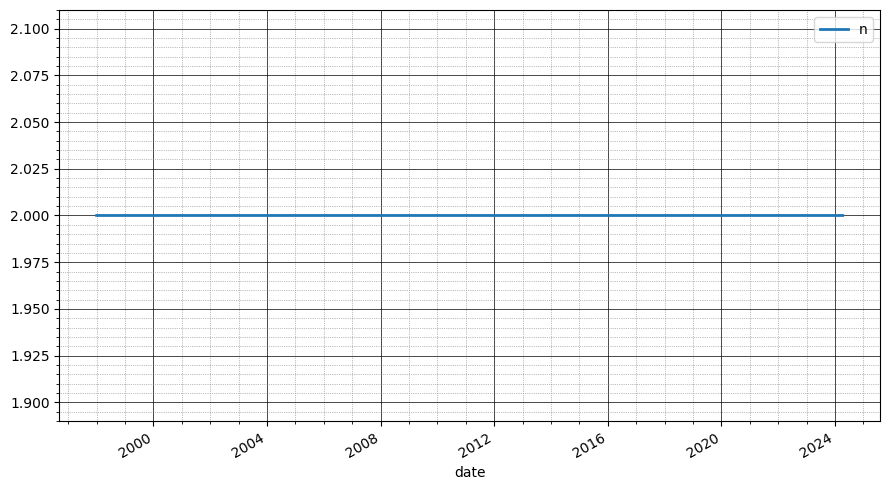

In [5]:
runs = []
for path in path_simus.glob('*'):
    if path.stem != 'dates':
        splits = path.stem.split('_')
        runs.append([splits[-1], '_'.join(splits[:-1])])
runs = (
    pl.DataFrame(runs, schema=['date', 'type'])
    .with_columns(has_run=pl.lit(True))
    .pivot(index='date', columns='type', values='has_run')
    .with_columns(pl.col('date').str.to_date('%y%m%d'))
)
print(runs.columns)
runs = (
    dates
    .join(runs, on='date', how='left')
    .with_columns(pl.all().fill_null(False))
    .with_columns(pl.concat_list(pl.exclude('date')).list.sum().alias('n'))
)
plot_ts(runs.select('date', 'n'), 'date')

In [6]:
runs.drop('date', 'n').sum()

covariances,returns
u32,u32
6609,6609


# Check lengths of runs

In [7]:
%%time

def ad_hoc(name, day):
    path = path_simus / f"{name}_{day.strftime('%y%m%d')}.parquet"
    return (
        pl.scan_parquet(path)
        .select(pl.len(), pl.concat_list(pl.all().null_count()).list.sum())
        .collect()
        .row(0)
    )

name = 'covariances'
lengths = [[day, *ad_hoc(name, day)] for day in dates.get_column('date')]
lengths = pl.DataFrame(lengths, schema=['date', 'len', 'n_null']).sort('date')

CPU times: user 3min 2s, sys: 40.9 s, total: 3min 43s
Wall time: 1min 18s


<Figure size 900x500 with 0 Axes>

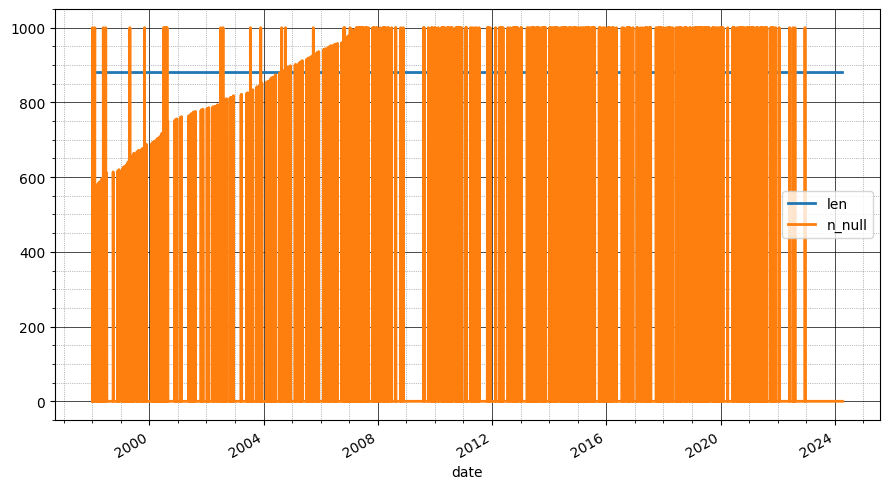

In [8]:
plot_ts(lengths.with_columns(pl.exclude('date').clip(0, 1000)), 'date')